In [1]:
#import des bibliothèques
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import custom_functions as cf
from mpl_toolkits.mplot3d import Axes3D
from sklearn import cluster, metrics, decomposition, preprocessing, manifold
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import random as rd


#Les options suivantes permettent d'afficher toutes les lignes et colonnes voulues lorsqu'on appelle la fonction print
pd.set_option("max_rows", None)
pd.set_option("max_columns", None)

#On importe le jeu de données
data = pd.read_csv('database_clients.csv')

# Visualisation des données

In [2]:
#On jette un oeil à cette database
data.head()

,customer_unique_id,Recence_derniere_cmd,Nombre_commandes,Plusieurs_commandes,Montant_total,Montant_dernier,Mean_review_score,Prix_moyen_articles
0,0000366f3b9a7992bf8c76cfdf3221e2,115.0,1,0,129.90,129.90,5.0,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118.0,1,0,18.90,18.90,4.0,18.90
2,0000f46a3911fa3c0805444483337064,541.0,1,0,69.00,69.00,3.0,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,325.0,1,0,25.99,25.99,4.0,25.99
4,0004aac84e0df4da2b147fca70cf8255,292.0,1,0,180.00,180.00,5.0,180.00


## ACP

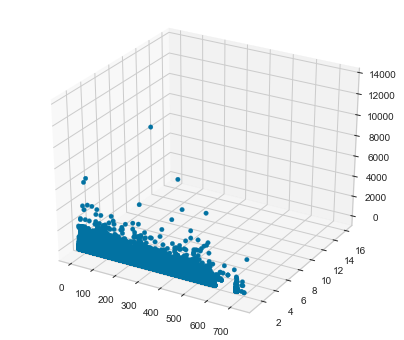

In [3]:
#On va afficher les individus selon les 3 variables RFM via un plot en 3D
fig = plt.figure(figsize=(7,6))
ax = plt.axes(projection='3d')
ax.scatter3D(data['Recence_derniere_cmd'], data['Nombre_commandes'], data['Montant_dernier'], alpha=1)
plt.show()

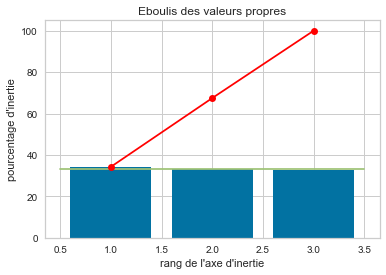

In [4]:
#On va faire une ACP, en ne considérant que les variables RFM
colonnes = ['Recence_derniere_cmd', 'Nombre_commandes', 'Montant_dernier']
n_comp = len(colonnes)

#On restreint notre database restreinte aux colonnes qui nous intéressent
data_pca = data[colonnes]

#On prépare les données pour l'ACP
data_pca = data_pca.fillna(data_pca.median()) # Il est fréquent de remplacer les valeurs inconnues par la mediane de la variable
X = data_pca.values
features = data_pca.columns

#Centrage et Réduction de nos données
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

#On affiche l'éboulis des valeurs propres
cf.ACP_eboulis(pca, n_comp)

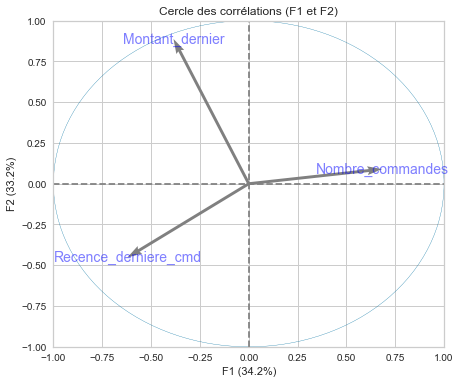

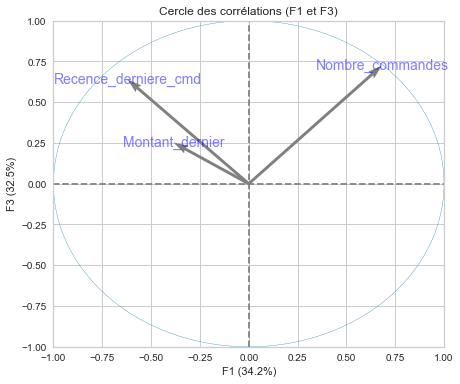

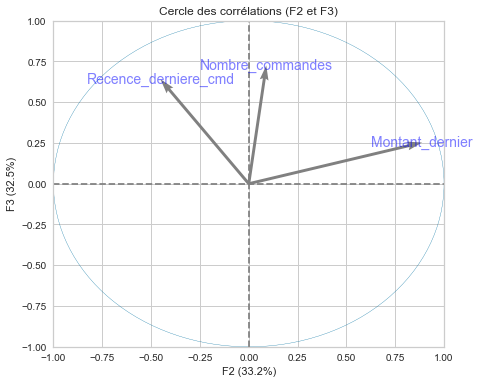

In [5]:
#On va afficher les cercles de corrélations, pour les 3 paires d'axes possibles
pcs = pca.components_
cf.ACP_cercles_correlation(pcs, n_comp, pca, [(0,1),(0,2),(1,2)], labels = colonnes)

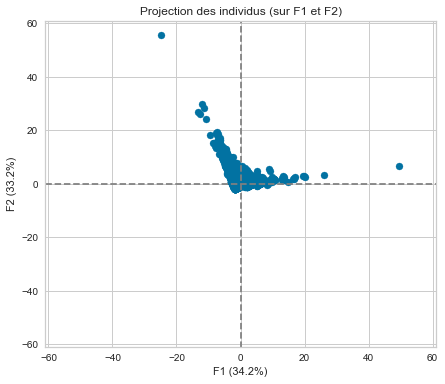

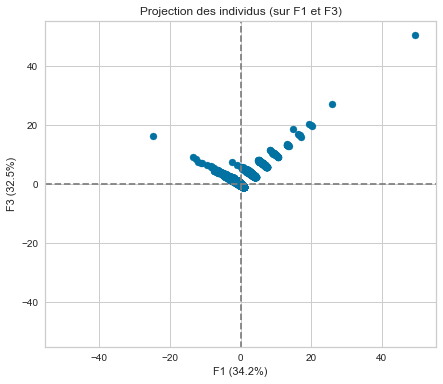

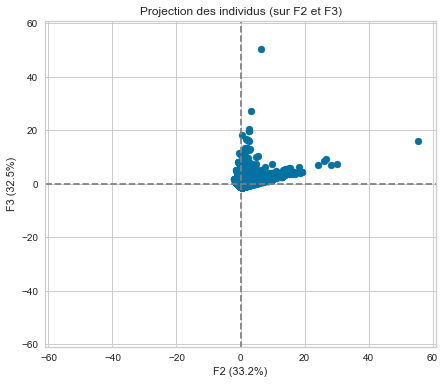

In [6]:
#Projection des individus sur les 3 plans factoriels possibles
X_projected = pca.transform(X_scaled)
cf.ACP_plans_factoriels(X_projected, n_comp, pca, [(0,1),(0,2),(1,2)])
plt.show()

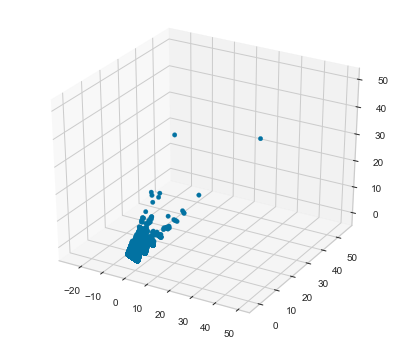

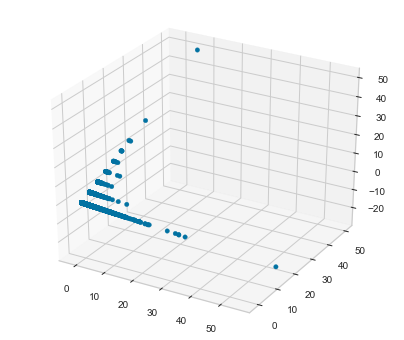

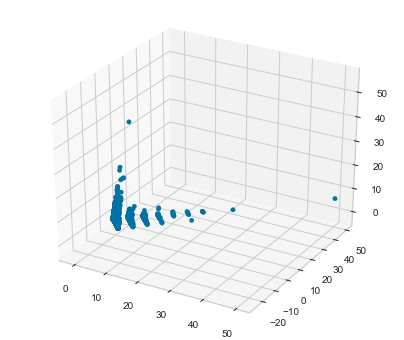

In [7]:
#On va afficher a nouveau les individus selon les axes obtenus par l'ACP, mais en 3D (donc selon les 3 axes)
def ACP_plans_factoriels_3D(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2,d3 in axis_ranks:
        if d3 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                ax = plt.axes(projection='3d')
                ax.scatter3D(X_projected[:, d1], X_projected[:, d2], X_projected[:, d3], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    ax = plt.axes(projection='3d')
                    ax.scatter3D(X_projected[:, d1], X_projected[:, d2], X_projected[:, d3], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
            plt.show(block=False)
        
#On va permuter les axes sur l'image pour avoir une meilleure visualisation des points
ACP_plans_factoriels_3D(X_projected, n_comp, pca, [(0,1,2)], labels=None, alpha=1, illustrative_var=None)
ACP_plans_factoriels_3D(X_projected, n_comp, pca, [(1,2,0)], labels=None, alpha=1, illustrative_var=None)
ACP_plans_factoriels_3D(X_projected, n_comp, pca, [(2,0,1)], labels=None, alpha=1, illustrative_var=None)

## t-SNE

In [8]:
#On va réduire la dimension du dataset via l'algorithme t-SNE, qui devrait commencer a séparer nos données 
X_embedded = manifold.TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(X_scaled)

X_embedded.shape

D:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


(95420, 2)

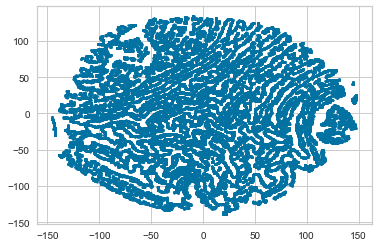

In [9]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], s=4)
plt.show()

Il ne semble pas y avoir de clusters apparents après l'usage de l'algorithme t-SNE.

# Algorithme k-means

In [10]:
#On isole et standardise les données d'intérêt pour nos modèles de clustering
X = data[colonnes]
X_norm = preprocessing.scale(X)

In [11]:
#On va s'intéresser au k-means, en comparant les coefficients de silhouette pour différentes valeurs de k
silhouettes = []
valeurs_k = range(2,10)
for num_clusters in valeurs_k:
    cls = cluster.KMeans(n_clusters=num_clusters, n_init=1, random_state=42)
    cls.fit(X_norm)
    silh = metrics.silhouette_score(X_norm, cls.labels_)
    silhouettes.append(silh)

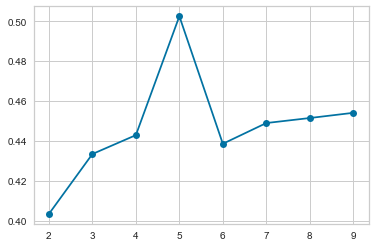

In [12]:
#On affiche le coefficient de silhouette
plt.plot(valeurs_k, silhouettes, marker='o')

In [13]:
#On récupère la "meilleure" valeur de k
N_clusters = valeurs_k[np.argmax(silhouettes)]
print(N_clusters)

5


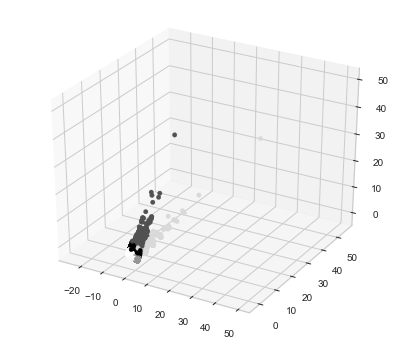

In [14]:
#On affiche nos individus en 3D, coloriés selon un k-means avec le k optimal calculé précédemment
cls = cluster.KMeans(n_clusters = N_clusters, random_state=42)
cls.fit(X_norm)
fig = plt.figure(figsize=(7,6))
ax = plt.axes(projection='3d')
ax.scatter3D(X_projected[:, 0], X_projected[:, 1], X_projected[:, 2], c=cls.labels_, alpha=1)
plt.show()

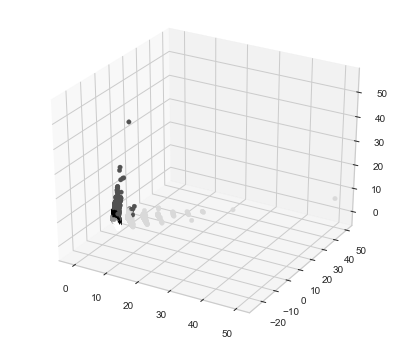

In [15]:
#On permute les axes pour mieux voir la répartition des points et clusters dans l'espace
fig = plt.figure(figsize=(7,6))
ax = plt.axes(projection='3d')
ax.scatter3D(X_projected[:, 2], X_projected[:, 0], X_projected[:, 1], c=cls.labels_, alpha=1)
plt.show()

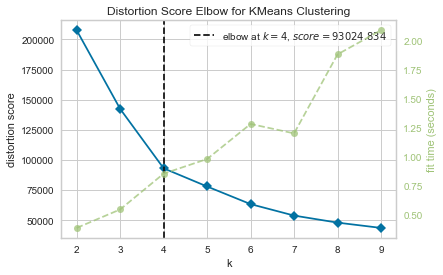

In [16]:
#On va utiliser KElbowVisualizer pour sélectionner k selon la méthode du coude pour le coefficient de distorsion
model = cluster.KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(X_norm)
#On récupère la valeur de k optimale selon ce nouveau critère de sélection
N_clusters_bis = visualizer.elbow_value_
visualizer.poof()

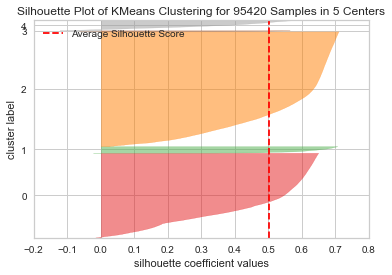

In [17]:
#On va visualiser le coefficient de silhouette de chaque individu, d'abord avec la valeur de k qui maximise ce coefficient
model1 = cluster.KMeans(N_clusters, random_state=42)
visualizer = SilhouetteVisualizer(model1)
visualizer.fit(X_norm) 
visualizer.poof() 

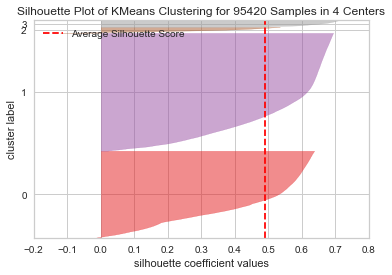

In [18]:
#Même chose mais avec le k sélectionné par la méthode du coude appliquée au coefficient de distorsion des clusters
model2 = cluster.KMeans(N_clusters_bis, random_state=42)
visualizer = SilhouetteVisualizer(model2)

visualizer.fit(X_norm)    # Fit the data to the visualizer
visualizer.poof() 

In [19]:
#On va créer des fonctions pour afficher la répartition des variables selon les différents clusters obtenus
def repart_variables_clusters(data, features, clustering_labels):
    clustering = pd.Series(clustering_labels, name='clustering')
    temp = pd.concat([data, clustering], axis=1)
    clusters = clustering.unique()
    n = len(clusters)
    f = len(features)
    fig = plt.figure(figsize=(10, 6*f))
    l=0
    for feat in features:
        l=l+1
        ax = fig.add_subplot(f, 1, l)
        donnees = []
        for i in range(n):
            truc = temp[temp['clustering'] == clusters[i]][feat].tolist()
            donnees.append(truc)
        ax.boxplot(donnees, labels=clusters, showfliers=True, flierprops=flierprops, medianprops=medianprops, 
                vert=True, patch_artist=True, showmeans=True, meanprops=meanprops)
        ax.set_title(feat, fontsize=14, fontweight='bold')
    plt.show()

def repart_clusters_variables(data, features, clustering_labels):
    clustering = pd.Series(clustering_labels, name='clustering')
    temp = pd.concat([data, clustering], axis=1)
    temp[features] = (temp[features]-temp[features].min())/(temp[features].max()-temp[features].min())
    clusters = clustering.unique()
    n = len(clusters)
    fig = plt.figure(figsize=(10, 6*n))
    l=0
    for i in range(n):
        l=l+1
        ax = fig.add_subplot(n, 1, l)
        print()
        donnees = []
        for feat in features:
            truc = temp[temp['clustering'] == clusters[i]][feat].tolist()
            donnees.append(truc)
        ax.set_ylim(-0.1,1.1)
        ax.boxplot(donnees, labels=features, showfliers=True, flierprops=flierprops, medianprops=medianprops, 
                vert=True, patch_artist=True, showmeans=True, meanprops=meanprops)
        ax.set_title('Cluster n°{} :'.format(clusters[i]), fontsize=14, fontweight='bold')
    plt.show()
    
#Quelques propriétés graphiques pour rendre les boxplots plus lisibles
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
flierprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'gray'}

D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


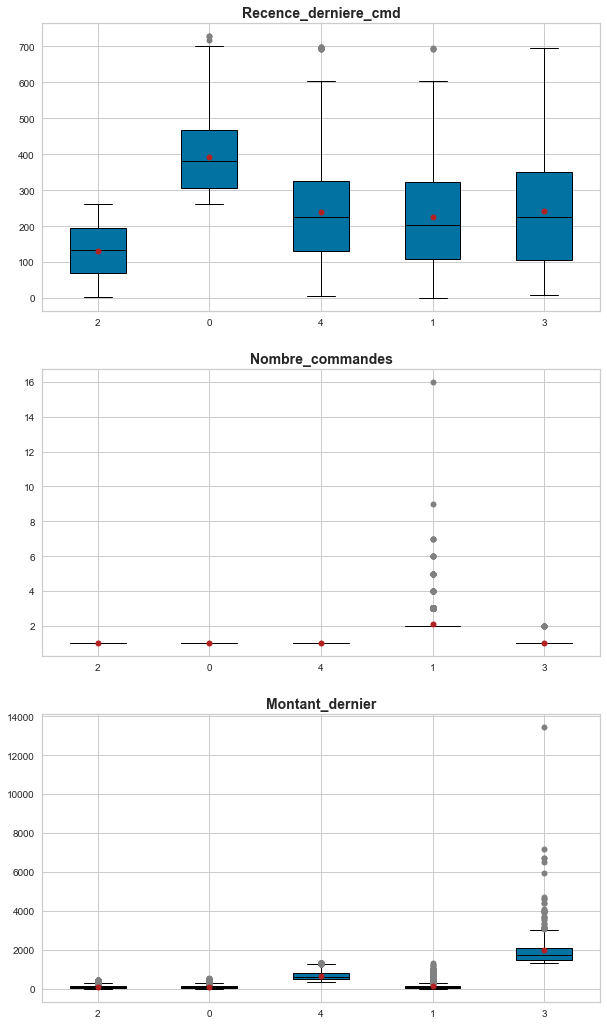

In [20]:
#On affiche les variables selon les différents clusters pour le 1er k-means (méthode silhouette)
repart_variables_clusters(data, colonnes, cls.labels_)

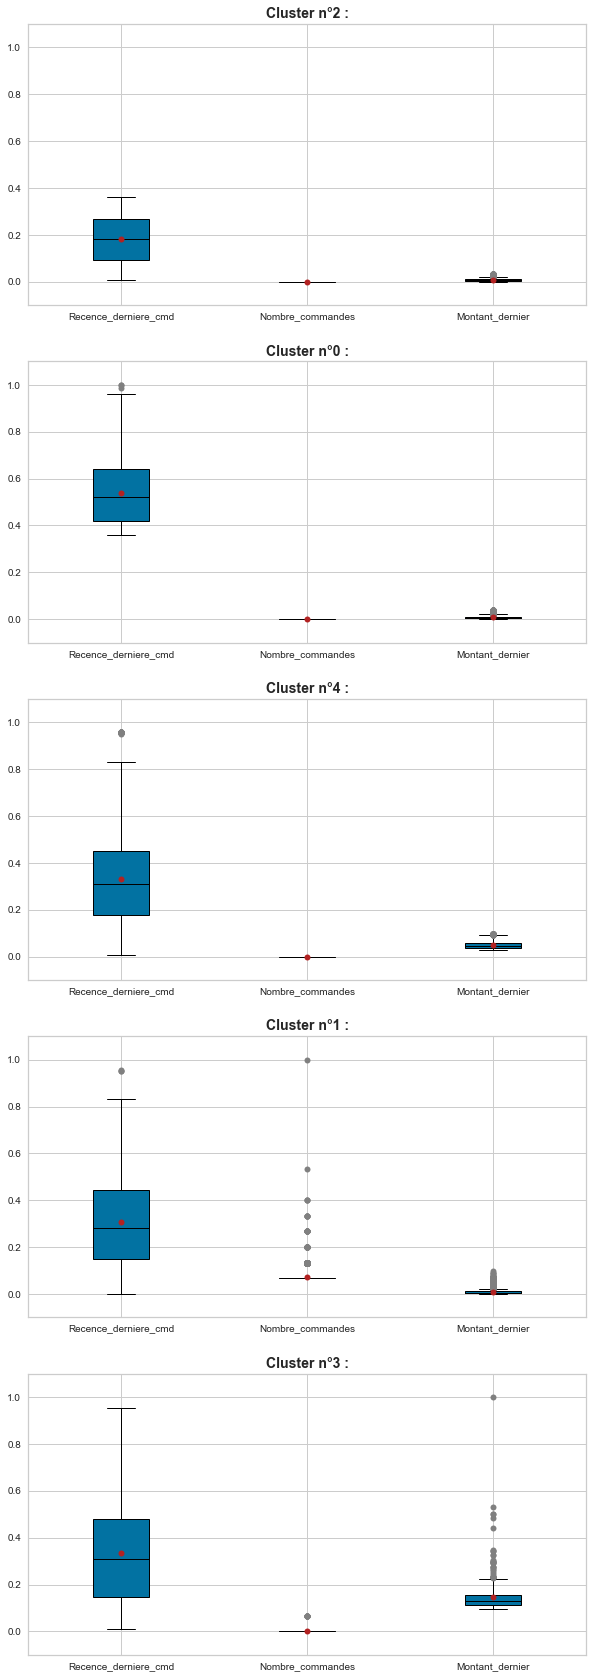

In [21]:
#On affiche la répartition des variables (renormalisées) dans chaque cluster afin d'en déduire une description
#concrète des critères d'appartenance a chaque cluster (toujours pour le 1er k-means)
repart_clusters_variables(data, colonnes, cls.labels_)

D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


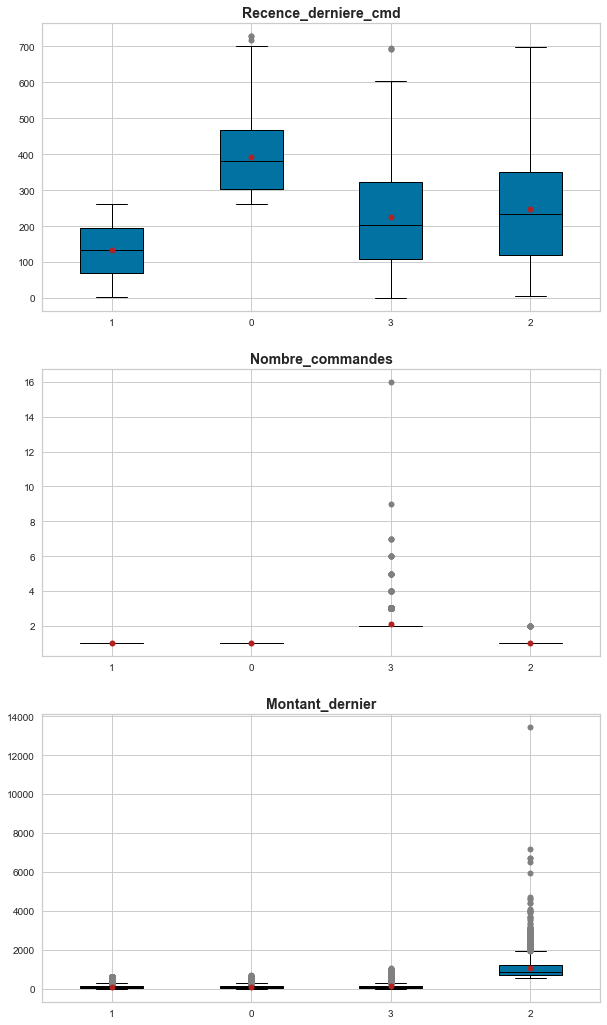

In [22]:
#On affiche les variables selon les différents clusters pour le 2nd k-means (méthode distortion)
cls2 = cluster.KMeans(n_clusters = N_clusters_bis, random_state=42)
cls2.fit(X_norm)
repart_variables_clusters(data, colonnes, cls2.labels_)

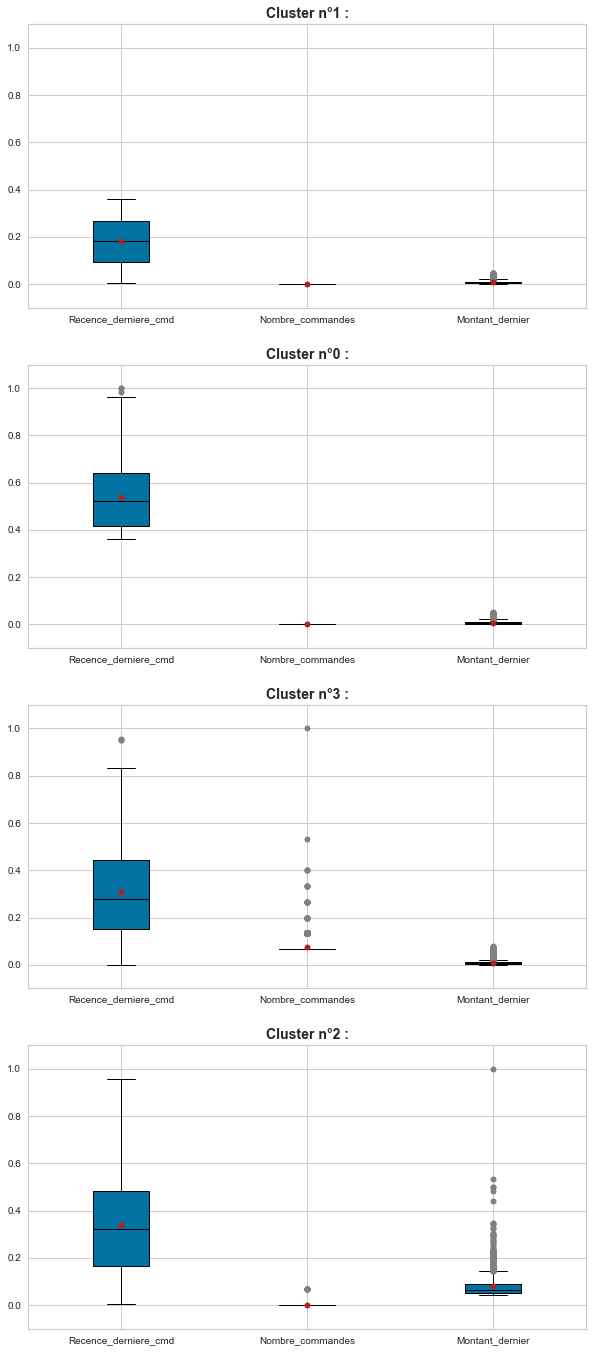

In [23]:
#On affiche la répartition des variables (renormalisées) dans chaque cluster afin d'en déduire une description
#concrète des critères d'appartenance a chaque cluster (toujours pour le 2nd k-means)
repart_clusters_variables(data, colonnes, cls2.labels_)

On essaye la même procédure mais cette fois avec les données représentées en 2 dimensions via l'algorithme t-SNE.

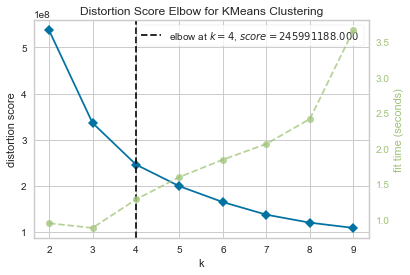

In [24]:
#On va chercher un k-means adapté a la réduction faite par le t-SNE
model = cluster.KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(X_embedded)
#On récupère la valeur de k optimale selon ce nouveau critère de sélection
N_clusters_tSNE = visualizer.elbow_value_
visualizer.poof()

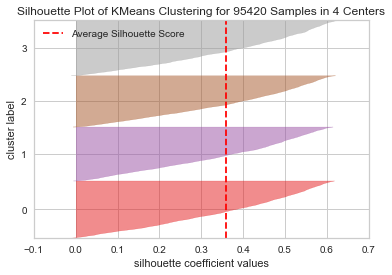

In [25]:
#Observons le coefficient de silhouette obtenu
model3 = cluster.KMeans(N_clusters_tSNE, random_state=42)
visualizer = SilhouetteVisualizer(model3)

visualizer.fit(X_embedded)    # Fit the data to the visualizer
visualizer.poof() 

D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


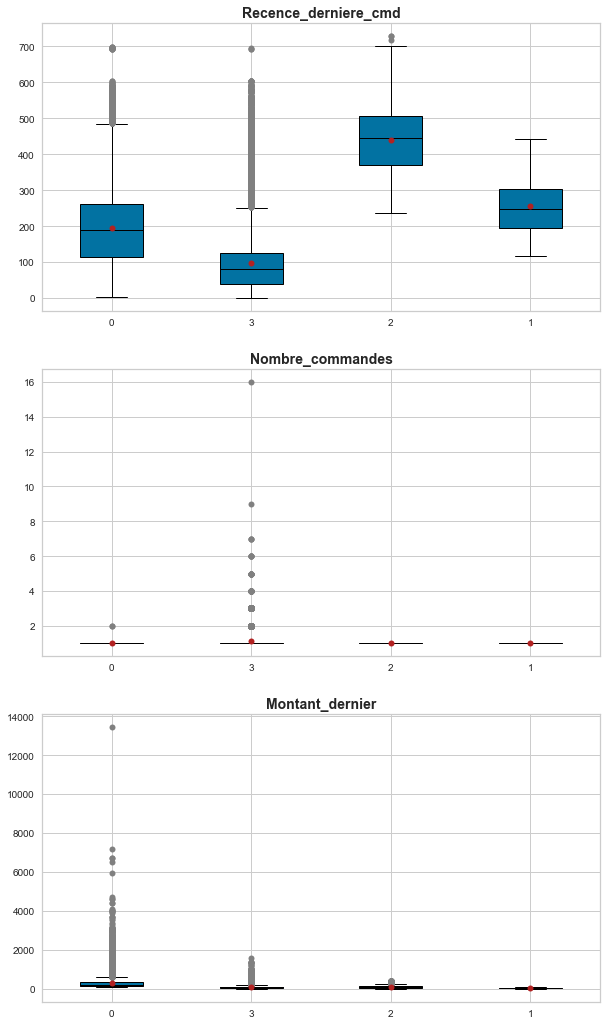

In [26]:
#On affiche les variables selon les différents clusters trouvés via cette méthode
cls3 = cluster.KMeans(n_clusters = N_clusters_tSNE, random_state=42)
cls3.fit(X_embedded)
repart_variables_clusters(data, colonnes, cls3.labels_)

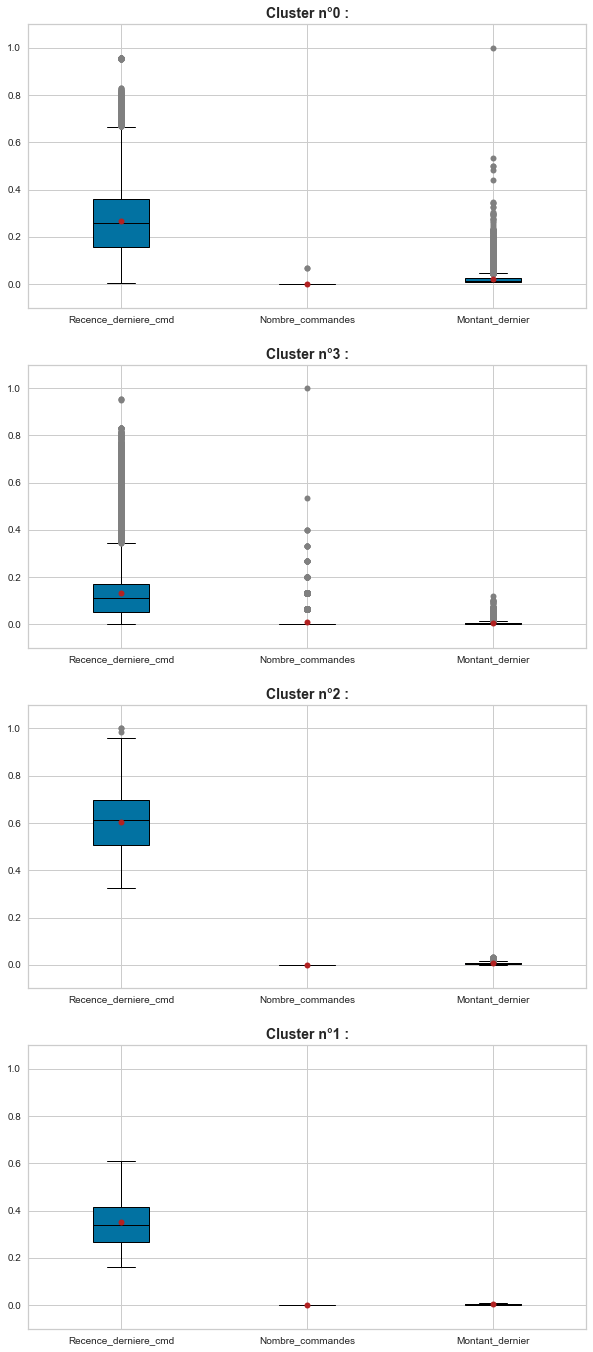

In [27]:
#On affiche la répartition des variables (renormalisées) dans chaque cluster afin d'en déduire une description
#concrète des critères d'appartenance a chaque cluster
repart_clusters_variables(data, colonnes, cls3.labels_)

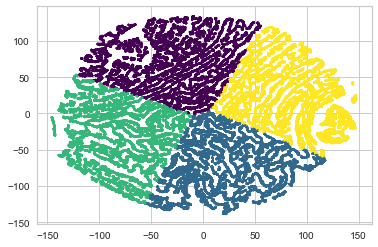

In [28]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], s=4, c=cls3.labels_, cmap='viridis')
plt.show()

La segmentation obtenue est moins évidente, mais la répartition des variables dans chaque cluster semble proche de celle obtenue pour le k-means sur les données initiales avec k=4.

# DBScan

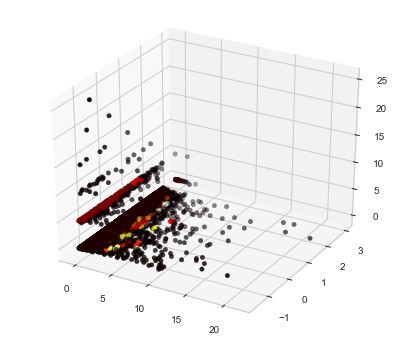

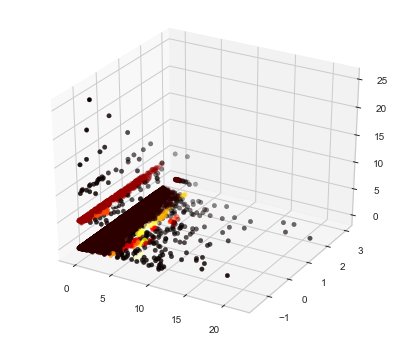

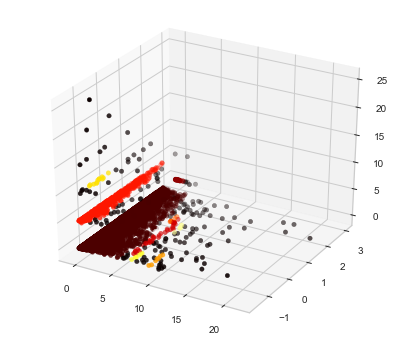

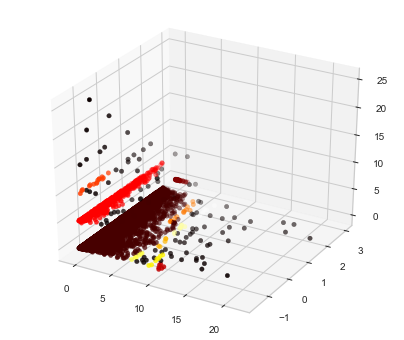

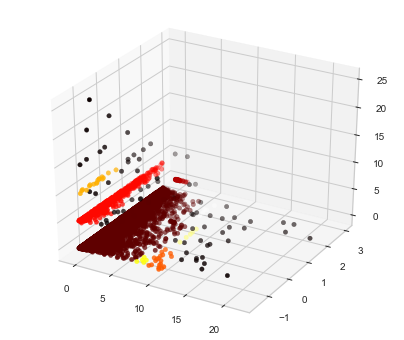

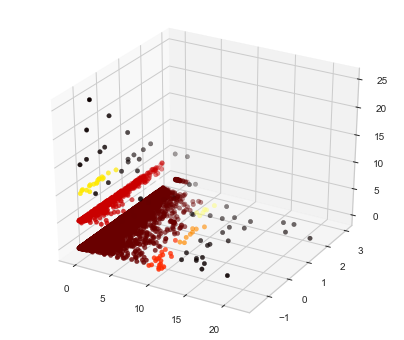

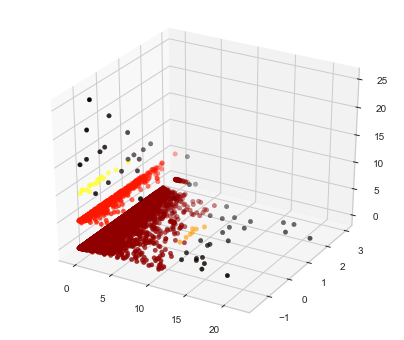

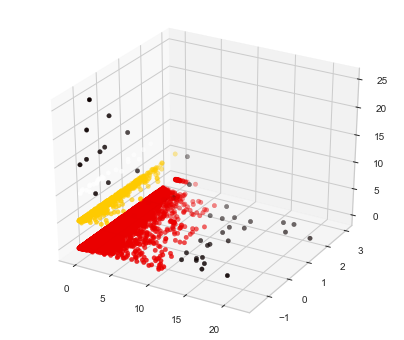

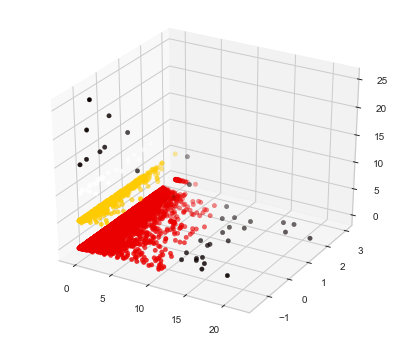

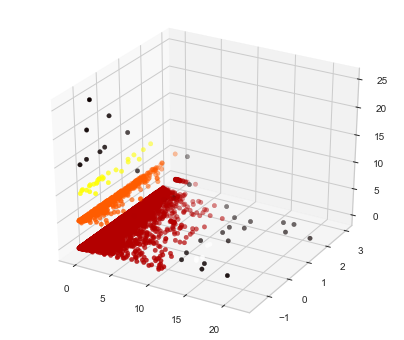

In [29]:
#On va utiliser l'algorithme DBScan (fourni par sklearn) pour essayer d'obtenir un clustering plus pertinent

#Pour identifier les bons hyperparamètres on va réduire le temps de calcul en travaillant sur un échantillon réduit
N = data.shape[0]
proportion = 0.2
sample_index = rd.sample(data.index.tolist(), int(proportion*N))
data_sample = data.loc[sample_index]
X = data_sample[colonnes]
X_norm = preprocessing.scale(X)

#On va comparer les coefficients de silhouette et le nombre de clusters pour différentes valeurs de epsilon
silhouettes = []
n_clusters = []
n_bruits = []
valeurs_eps = np.linspace(0.1, 1, 10)
for epsilon in valeurs_eps:
    # Segmentation à l'aide d'un dbscan'
    dbscan = cluster.DBSCAN(eps=epsilon, min_samples=5).fit(X_norm)
    
    clusters = dbscan.labels_.tolist()
    n_clusters.append(max(clusters) + 1)
    
    noise_labels = [i for i,x in enumerate(clusters) if x==-1]
    n_bruits = len(noise_labels)
    
    X_calc = np.delete(X_norm, noise_labels, 0)
    
    for index in sorted(noise_labels, reverse=True):
        del clusters[index]

    silhouettes.append(metrics.silhouette_score(X_calc, clusters, metric='euclidean'))
    
    
    # Visualisation du résultat
    fig = plt.figure(figsize=(7,6))
    ax = plt.axes(projection='3d')
    ax.scatter3D(X_norm[:, 2], X_norm[:, 0], X_norm[:, 1], c=dbscan.labels_, cmap=plt.get_cmap("hot"))
    plt.show()


Coefficients de silhouette


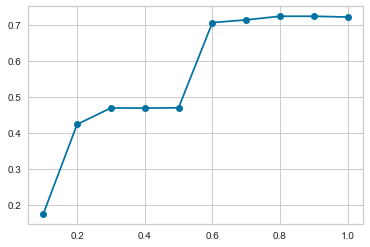

Nombre de clusters


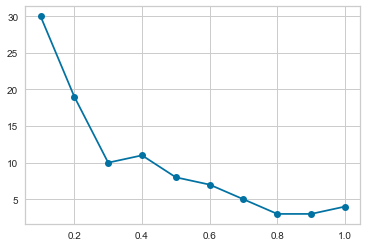

In [30]:
#On affiche les coefficients de silhouette selon epsilon
print('Coefficients de silhouette')
plt.plot(valeurs_eps, silhouettes, marker='o')
plt.show()
#On affiche le nombre de clusters selon epsilon
print('Nombre de clusters')
plt.plot(valeurs_eps, n_clusters, marker='o')
plt.show()

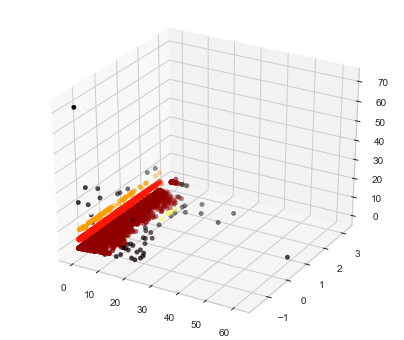

DBScan avec epsilon = 0.65, 5 clusters détectés et 64 individus mis de côté. Coefficient de silhouette moyen : 0.7103418429132244


In [31]:
#On va appliquer le meilleur DBScan (ici avec epsilon = 0.65)
epsilon = 0.65

#On utlisera davantage de données (50% de la database), mais pas la totalité (l'ordinateur ne parvient pas a suivre)
N = data.shape[0]
proportion = 0.5
sample_index = rd.sample(data.index.tolist(), int(proportion*N))
data_sample = data.loc[sample_index]
X = data_sample[colonnes]
X_norm = preprocessing.scale(X)



dbscan = cluster.DBSCAN(eps=epsilon, min_samples=5).fit(X_norm)
    
clusters = dbscan.labels_.tolist()
n_clusters = max(clusters) + 1 
noise_labels = [i for i,x in enumerate(clusters) if x==-1]
n_bruits = len(noise_labels)
X_calc = np.delete(X_norm, noise_labels, 0)  
for index in sorted(noise_labels, reverse=True):
    del clusters[index]
coeff_sil = metrics.silhouette_score(X_calc, clusters, metric='euclidean')
    
fig = plt.figure(figsize=(7,6))
ax = plt.axes(projection='3d')
ax.scatter3D(X_norm[:, 2], X_norm[:, 0], X_norm[:, 1], c=dbscan.labels_, cmap=plt.get_cmap("hot"))
plt.show()

print("DBScan avec epsilon = {}, {} clusters détectés et {} individus mis de côté. Coefficient de silhouette moyen : {}"\
      .format(epsilon, n_clusters, n_bruits, coeff_sil))

D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


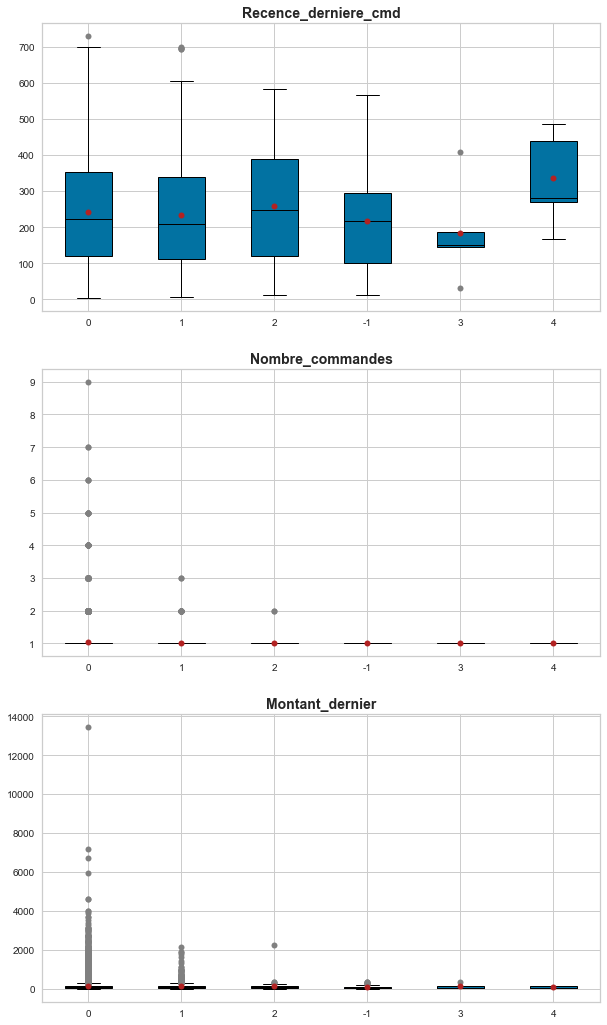

In [32]:
#On affiche les variables selon les différents clusters pour le dbscan
repart_variables_clusters(data, colonnes, dbscan.labels_)

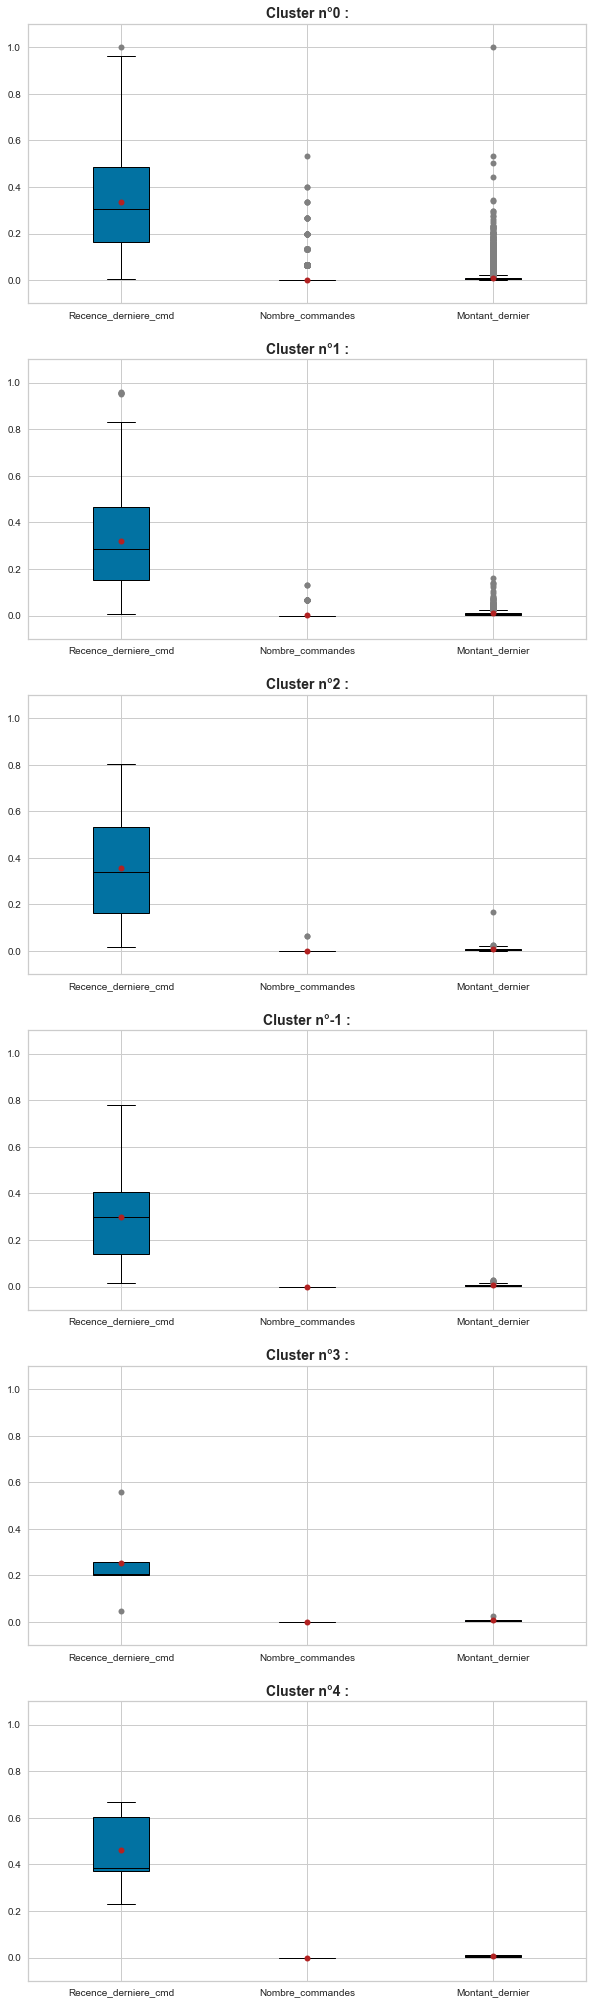

In [33]:
#On affiche la répartition des variables (renormalisées) dans chaque cluster afin d'en déduire une description
#concrète des critères d'appartenance a chaque cluster (toujours pour le dbscan)
repart_clusters_variables(data, colonnes, dbscan.labels_)

# CAH

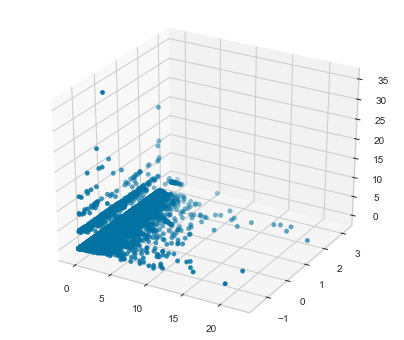

In [34]:
#On va essayer avec une CAH, toujours dans le but d'obtenir une segmentation aussi pertinente que possible
#Pour la CAH on va devoir travailler sur un sous-échantillon réduit
N = data.shape[0]
proportion = 0.2
sample_index = rd.sample(data.index.tolist(), int(proportion*N))
data_sample = data.loc[sample_index]
X = data_sample[colonnes]
X_norm = preprocessing.scale(X)

#On affiche notre jeu de données réduit selon nos 3 variable pour s'assurer qu'il a le même profil que le jeu initial
fig = plt.figure(figsize=(7,6))
ax = plt.axes(projection='3d')
ax.scatter3D(X_norm[:, 2], X_norm[:, 0], X_norm[:, 1])
plt.show()

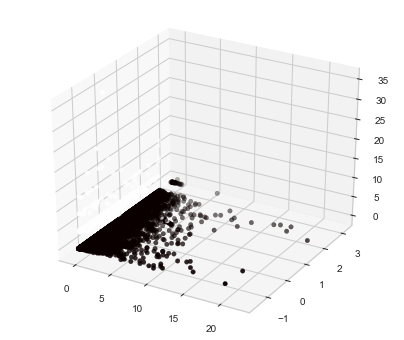

coefficient de silhouette pour 2 clusters : 0.7195363254570575


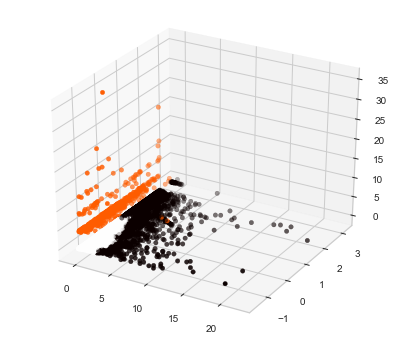

coefficient de silhouette pour 3 clusters : 0.4720498800926657


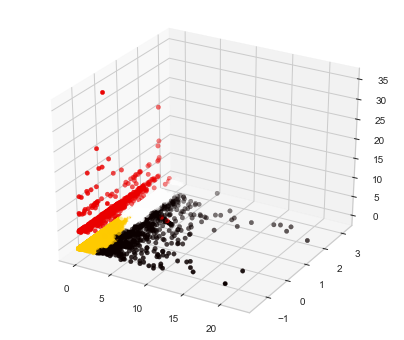

coefficient de silhouette pour 4 clusters : 0.49089736316071647


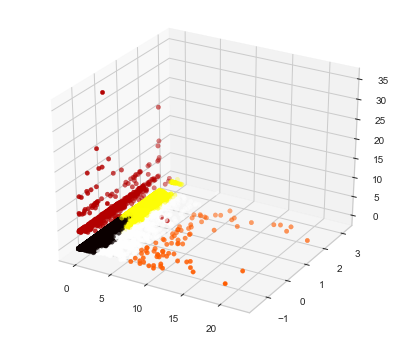

coefficient de silhouette pour 5 clusters : 0.4945201812640379


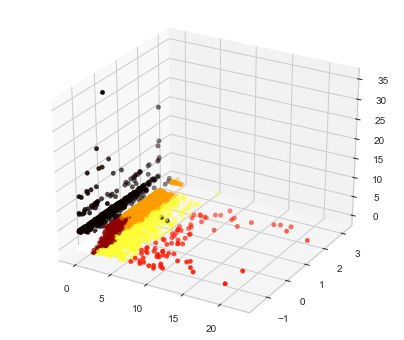

coefficient de silhouette pour 6 clusters : 0.38460900370502216


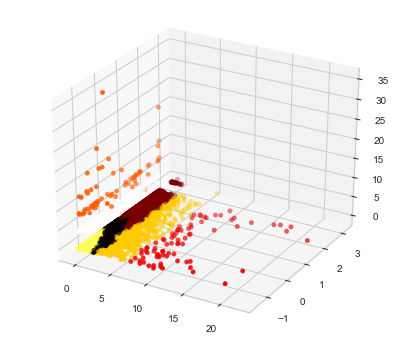

coefficient de silhouette pour 7 clusters : 0.38800011158012826


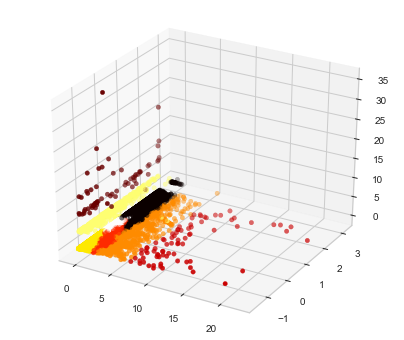

coefficient de silhouette pour 8 clusters : 0.37541381806460455


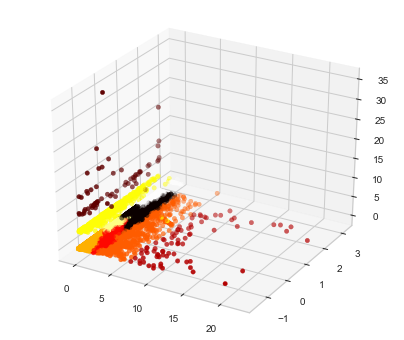

coefficient de silhouette pour 9 clusters : 0.3583707317927164


In [35]:
#On va comparer les coefficients de silhouette pour différentes valeurs de k, le nombre de clusters
silhouettes = []
valeurs_k = range(2,10)
for k in valeurs_k:
    # Segmentation à l'aide d'une CAH
    y_pred = cluster.AgglomerativeClustering(n_clusters = k).fit_predict(X_norm)

    # Visualisation du résultat
    fig = plt.figure(figsize=(7,6))
    ax = plt.axes(projection='3d')
    ax.scatter3D(X_norm[:, 2], X_norm[:, 0], X_norm[:, 1], c=y_pred, cmap=plt.get_cmap("hot"))
    plt.show()
    
    temp = metrics.silhouette_score(X_norm, y_pred, metric='euclidean')
    print("coefficient de silhouette pour {} clusters : {}".format(k, temp))
    silhouettes.append(temp)

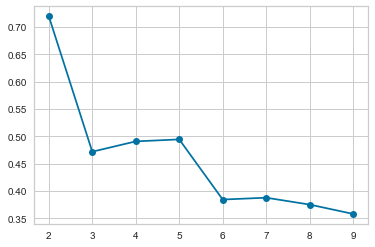

In [36]:
#On affiche les coefficients de silhouette selon k
plt.plot(valeurs_k, silhouettes, marker='o')

In [37]:
#On récupère le nombre optimal de clusters pour notre CAH
N_clusters_cah = valeurs_k[np.argmax(silhouettes)]
print(N_clusters_cah)

2


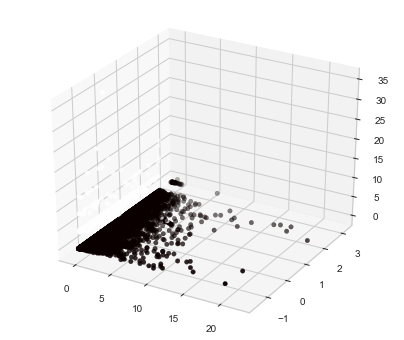

coefficient de silhouette pour 2 clusters : 0.7195363254570575


In [38]:
# Segmentation à l'aide d'une CAH avec le nombre optimal de clusters (selon le coefficient de silhouette)
y_pred = cluster.AgglomerativeClustering(n_clusters = N_clusters_cah).fit_predict(X_norm)

# Visualisation du résultat
fig = plt.figure(figsize=(7,6))
ax = plt.axes(projection='3d')
ax.scatter3D(X_norm[:, 2], X_norm[:, 0], X_norm[:, 1], c=y_pred, cmap=plt.get_cmap("hot"))
plt.show()

silhouette = metrics.silhouette_score(X_norm, y_pred, metric='euclidean')

print("coefficient de silhouette pour {} clusters : {}".format(N_clusters_cah, silhouette))

D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


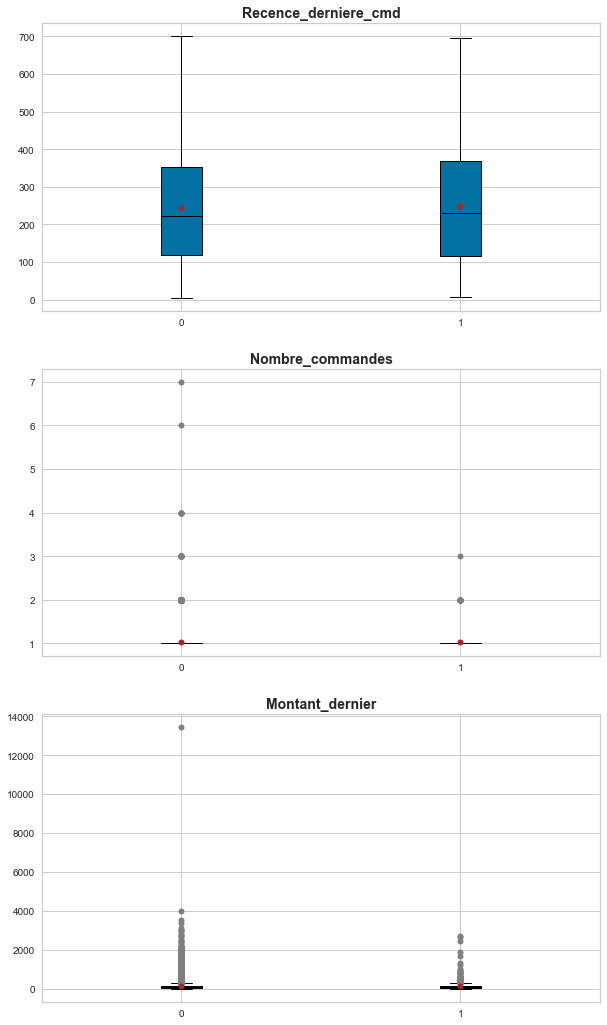

In [39]:
#On affiche les variables selon les différents clusters pour la cah
repart_variables_clusters(data, colonnes, y_pred)

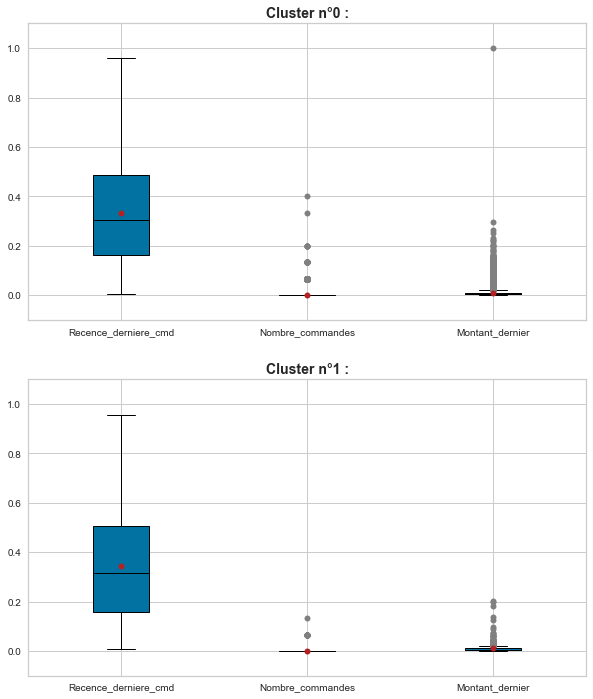

In [40]:
#On affiche la répartition des variables (renormalisées) dans chaque cluster afin d'en déduire une description
#concrète des critères d'appartenance a chaque cluster (toujours pour la cah)
repart_clusters_variables(data, colonnes, y_pred)

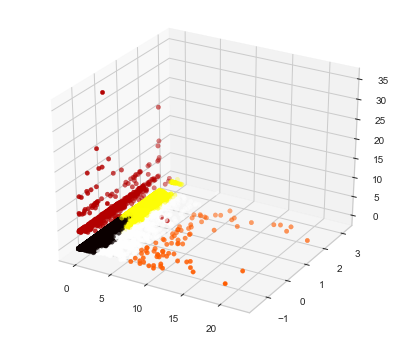

coefficient de silhouette pour 5 clusters : 0.4945201812640379


In [41]:
# LOn va aussi essayer avec 5 clusters, choix qui peut être intéressant au vu des coefficients de silhouette
N_clusters_cah = 5
y_pred = cluster.AgglomerativeClustering(n_clusters = N_clusters_cah).fit_predict(X_norm)

# Visualisation du résultat
fig = plt.figure(figsize=(7,6))
ax = plt.axes(projection='3d')
ax.scatter3D(X_norm[:, 2], X_norm[:, 0], X_norm[:, 1], c=y_pred, cmap=plt.get_cmap("hot"))
plt.show()

silhouette = metrics.silhouette_score(X_norm, y_pred, metric='euclidean')

print("coefficient de silhouette pour {} clusters : {}".format(N_clusters_cah, silhouette))

D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


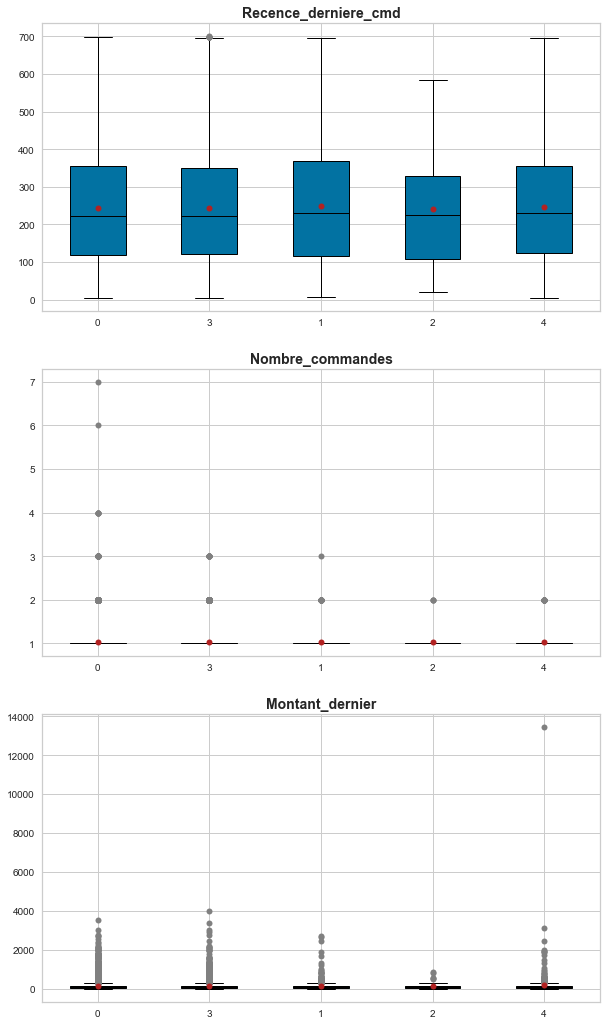

In [42]:
#On affiche les variables selon les différents clusters pour la cah
repart_variables_clusters(data, colonnes, y_pred)

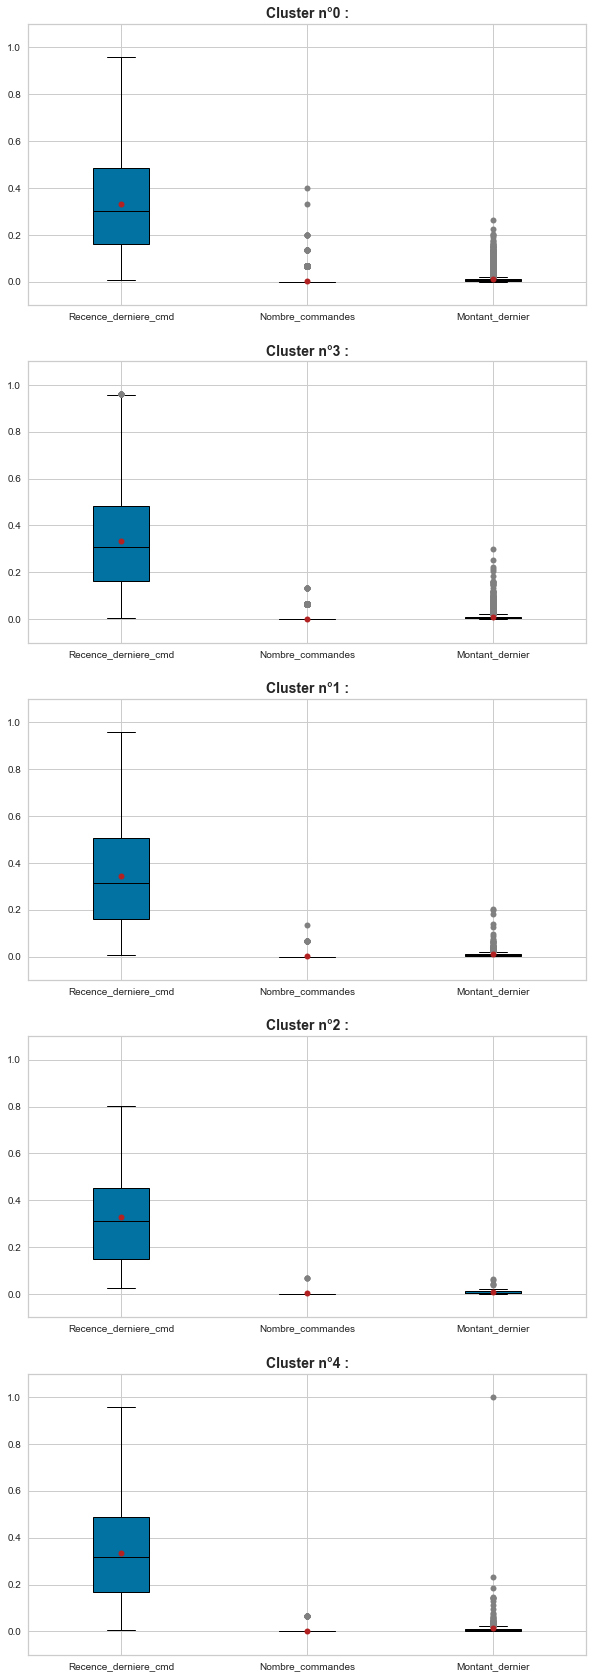

In [43]:
#On affiche la répartition des variables (renormalisées) dans chaque cluster afin d'en déduire une description
#concrète des critères d'appartenance a chaque cluster (toujours pour la cah)
repart_clusters_variables(data, colonnes, y_pred)

# Conclusions

Pour l'algorithme k-means, les valeurs de $k$ pertinentes seraient $k=4$ et $k=5$, qui amènent un coefficient de silhouette moyen d'environ $0,50$. Les répartitions dans les différents clusters semblent compréhensibles en termes des variables utilisées (pour $k=4$, un cluster contient les utilisateurs ayant fait plusieurs commandes, un autre les montant très élevés, et les deux derniers se distinguent par la date de la dernière commande). La modification des données par l'lgorithme t-SNE ne semble que très peu changer cette segmentation.

Pour l'algorithme DBScan, le paramètre retenu est $\epsilon = 0.65$, qui détecte $6$ clusters. Le coefficient de silhouette moyen obtenu est d'environ $0,72$. En revanche il semble difficile de décrire simplement les différents clusters à l'aide des variables utilisées.

Pour l'algorithme CAH, il semblerait que le nombre de clusters optimal soit $k=2$, avec un coefficient de silhouette moyen  de $0,74$ mais les deux clusters sont difficiles à différencier, hormis par le nombre de commandes. La CAH à $5$ clusters abaisse grandement le coefficient de silhouette mais malheureusement se contente de classer les clients selon leur nombre de commandes.

Nous retiendrons donc l'algorithme k-means avec k=4.